In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

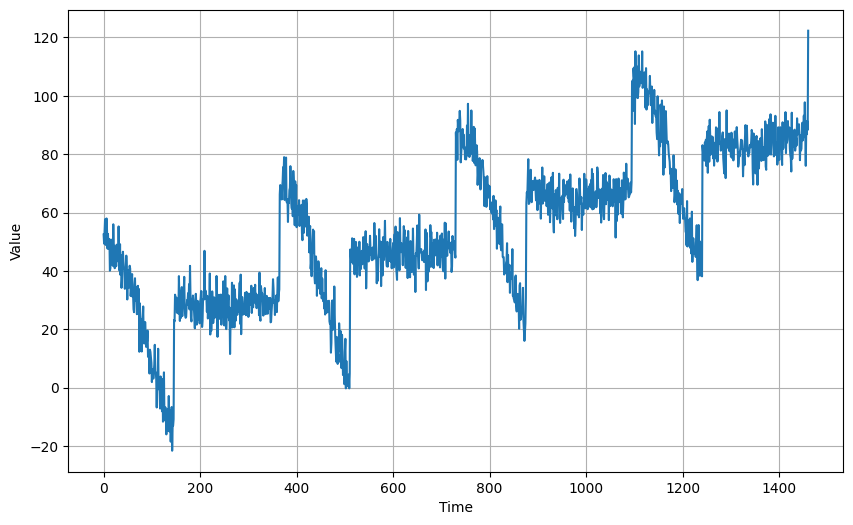

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 4s 278ms/step - loss: 140.2334 - mae: 140.7334 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 87.4048 - mae: 87.9048 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 29.0031 - mae: 29.4993 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 32.7654 - mae: 33.2628 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 22.8077 - mae: 23.3029 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 78ms/step - loss: 19.9498 - mae: 20.4407 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 18.8624 - mae: 19.3513 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 38ms/step - loss: 18.1999 - mae: 18.6909 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 36ms/step - loss: 17.4226 - mae: 17.9119 - lr: 2.5119e-07
E

(1e-07, 0.0001, 0.0, 30.0)

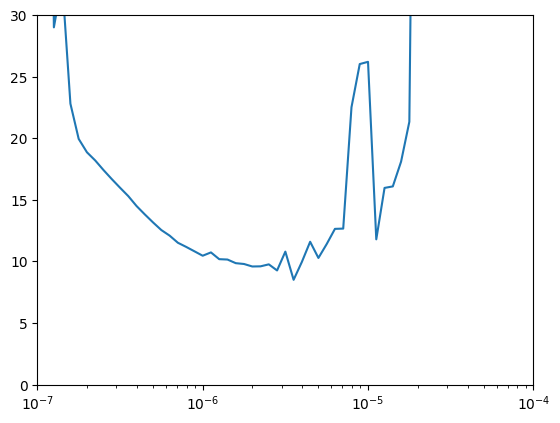

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 35ms/step - loss: 96.8176 - mae: 97.3176  INFO:tensorflow:Assets written to: my_checkpoint\assets
8/8 [==============================] - 7s 704ms/step - loss: 96.5145 - mae: 97.0141 - val_loss: 33.2761 - val_mae: 33.7756
Epoch 2/500
8/8 [==============================] - 1s 83ms/step - loss: 61.0558 - mae: 61.5538 - val_loss: 111.7085 - val_mae: 112.2085
Epoch 3/500
8/8 [==============================] - 9s 1s/step - loss: 38.3541 - mae: 38.8519 - val_loss: 16.1140 - val_mae: 16.6061
Epoch 4/500
8/8 [==============================] - 6s 766ms/step - loss: 21.1614 - mae: 21.6580 - val_loss: 9.7585 - val_mae: 10.2455
Epoch 5/500
8/8 [==============================] - 4s 524ms/step - loss: 16.9704 - mae: 17.4634 - val_loss: 8.7741 - val_mae: 9.2579
Epoch 6/500
8/8 [==============================] - 3s 445ms/step - loss: 14.7466 - mae: 15.2392 - val_loss: 8.2055 - val_mae: 8.6925
Epoch 7/500
8/8 [==============================] - 3s 386ms/step - loss: 12.94

In [8]:
model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 14ms/step


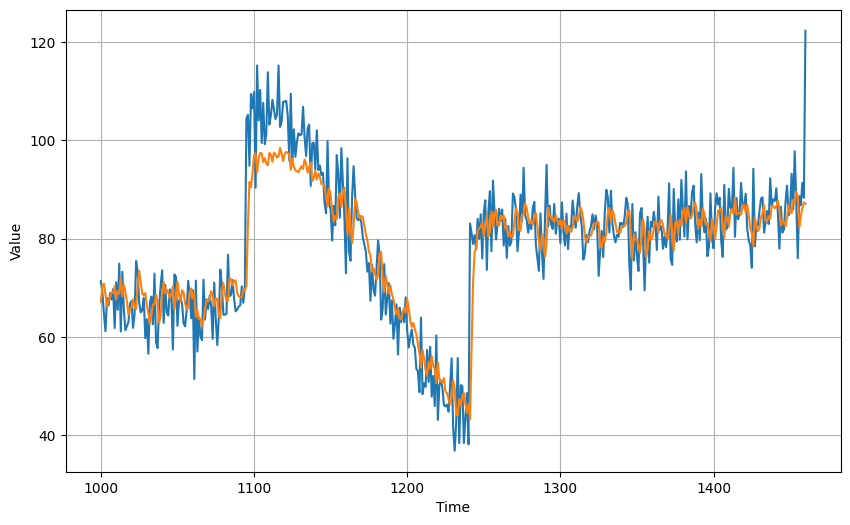

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.2598023

## Sequence-to-Sequence Forecasting

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 73ms/step - loss: 95.7434 - mae: 96.2434 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 68ms/step - loss: 46.9437 - mae: 47.4408 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 1s 61ms/step - loss: 42.3396 - mae: 42.8374 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 1s 59ms/step - loss: 34.8401 - mae: 35.3372 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 1s 58ms/step - loss: 26.8559 - mae: 27.3466 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 1s 59ms/step - loss: 22.5980 - mae: 23.0888 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 1s 56ms/step - loss: 20.5704 - mae: 21.0610 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 49ms/step - loss: 19.8072 - mae: 20.2970 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 50ms/step - loss: 19.3280 - mae: 19.8177 - lr: 1.8478e-07
Epoc

(1e-07, 0.0001, 0.0, 30.0)

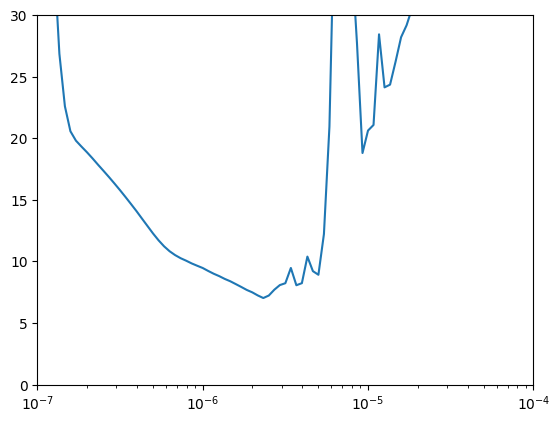

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 191ms/step - loss: 153.4995 - mae: 153.9992 - val_loss: 30.2225 - val_mae: 30.7201
Epoch 2/500
8/8 [==============================] - 1s 67ms/step - loss: 59.6089 - mae: 60.1085 - val_loss: 16.8586 - val_mae: 17.3457
Epoch 3/500
8/8 [==============================] - 1s 86ms/step - loss: 30.5193 - mae: 31.0170 - val_loss: 22.2548 - val_mae: 22.7526
Epoch 4/500
8/8 [==============================] - 1s 89ms/step - loss: 21.6686 - mae: 22.1640 - val_loss: 24.8731 - val_mae: 25.3720
Epoch 5/500
8/8 [==============================] - 1s 69ms/step - loss: 16.9993 - mae: 17.4925 - val_loss: 11.0506 - val_mae: 11.5363
Epoch 6/500
8/8 [==============================] - 1s 68ms/step - loss: 13.7061 - mae: 14.1958 - val_loss: 10.5016 - val_mae: 10.9914
Epoch 7/500
8/8 [==============================] - 1s 70ms/step - loss: 12.3470 - mae: 12.8359 - val_loss: 11.7426 - val_mae: 12.2360
Epoch 8/500
8/8 [==============================] - 1s 67ms/

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 7ms/step


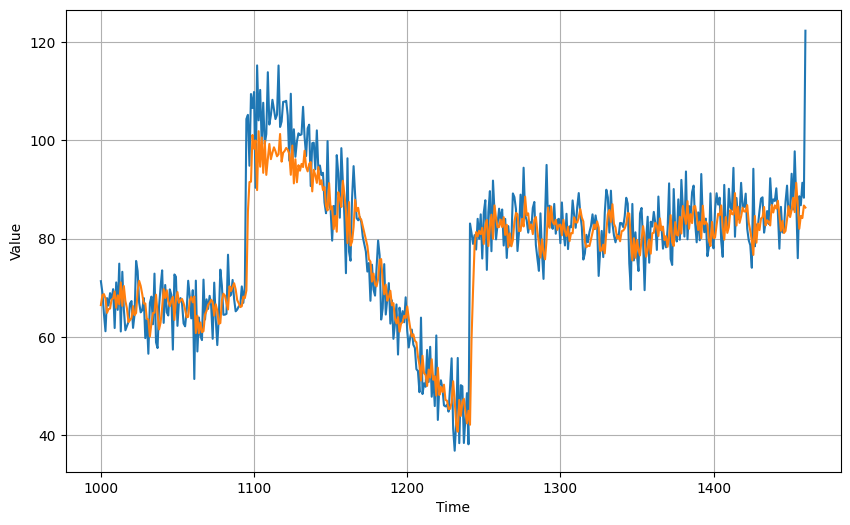

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.193804